# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import dill
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import janitor
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
                              GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [23]:
import joblib
import requests
import warnings
from dotenv import load_dotenv
load_dotenv()
APIKEY = os.getenv("SOME_KEY")
%reload_ext watermark
%watermark -a 'Ken Cavagnolo' -n -u -v -m -h -g -p jupyter,notebook,pandas,numpy,scipy

Author: Ken Cavagnolo

Last updated: Fri Oct 01 2021

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.25.0

jupyter : 1.0.0
notebook: 6.4.0
pandas  : 1.3.0
numpy   : 1.19.5
scipy   : 1.7.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.13.0-7614-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Hostname: goldfinch

Git hash: caf9afbd6f40785ca9287d672399bd2a69d694e9



# GPU Check

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import torch
from tensorflow.python.client import device_lib

hello = tf.constant("Hello, TensorFlow!")
with tf.device("/gpu:0"):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name="a")
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name="b")
    c = tf.matmul(a, b)
print("-" * 20)
print("<<< Testing Tensorflow >>>")
print("<<< Version: ", tf.__version__)
print("<<< Eager mode: ", tf.executing_eagerly())
print("<<< Hub version: ", hub.__version__)
print(
    "<<< GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE",
)
print("<<< Code check...")
tf.print(hello)
tf.print(c)
print("-" * 20)

# torch
print("-" * 20)
print("<<< Testing Torch >>>")
print(f"<<< Version: {torch.__version__}")
print(
    "<<< GPU is",
    "available"
    if any("GPU" in d.name for d in device_lib.list_local_devices())
    else "NOT AVAILABLE",
)
print("<<< CUDA is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print("<<< Code check...")
x = torch.rand(5, 3)
print(x)
print("-" * 20)


# Functions

In [21]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.

        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError(
            'multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError(
            'Some classes do not have enough examples. Change min_count if necessary.'
        )

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warnings.warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(
        seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices,
                                        size=min_count,
                                        replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])

In [7]:
def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]

In [8]:
def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y,
                                      size=size,
                                      min_count=min_count,
                                      seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask],
            Y[test_set_mask])

In [9]:
def score_submission(pred_path=None,
                     holdout_path=None):
    # this happens on the backend to get the score
    holdout_labels = pd.get_dummies(
        pd.read_csv(holdout_path,
                    index_col=0).apply(lambda x: x.astype('category'), axis=0))

    preds = pd.read_csv(pred_path, index_col=0)

    # make sure that format is correct
    assert (preds.columns == holdout_labels.columns).all()
    assert (preds.index == holdout_labels.index).all()

    return _multi_multi_log_loss(preds.values, holdout_labels.values)

In [10]:
from itertools import combinations
import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

# Load Data

In [11]:
# load data and use pyjanitor to clean
df = pd.read_csv("datasets/train.csv", index_col=0)
#test_df = pd.read_csv("datasets/test.csv", index_col=0)
#holdout_df = pd.read_csv("datasets/holdout.csv", index_col=0)

In [12]:
df.sample(5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
159481,Physical Health & Services,Pupil Services & Enrichment,School Reported,School,Unspecified,Nurse,Benefits,NO_LABEL,PreK-12 Operating,CONTRA BENEFITS,...,NaN,NaN,NaN,NON-PROJECT,NaN,UNDESIGNATED,-1240.090000,EMPLOYEE BENEFITS,NaN,EMPLOYEE BENEFITS
225044,Professional Development,ISPD,Shared Services,Non-School,ELL,Teacher,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,ADDITIONAL/EXTRA DUTY PAY/STIP,...,NaN,ENGLISH FOR SPEAKERS OF OTHER,NaN,TITLE III ELA,NaN,PROFESSIONAL-INSTRUCTIONAL,189.605760,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
71959,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Disadvantaged Youth *,NaN,NaN,NaN,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I CARRYOVER-PUBLIC
151756,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Instruction And Curriculum Development Services *,NaN,NaN,4630.960000,NaN,Special Trust,ITEMS-VARIOUS GRANTS
256188,Facilities & Maintenance,O&M,Shared Services,Non-School,Unspecified,Custodian,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Custodians,...,NaN,District Wide Resources,0.172794,NaN,CUSTODIANS,CUSTODIAN,2898.904889,Operations,General Purpose School,NaN


In [13]:
# inspect
#profile_report = df.profile_report(sort=None,
#                                         explorative=True,
#                                         html={"style": {
#                                             "full_width": True
#                                         }},
#                                         progress_bar=True)
#profile_report.to_file("docs/train_profile.html")

# EDA

## Categorical Features

In [14]:
# look for possible categorical columns
MIN_CATEGORIES = 2
MAX_CATEGORIES = 40
categorical_cols = []
print("Possibly categorical columns...")   
for col in sorted(df.select_dtypes(include=["object"]).columns):
    if MIN_CATEGORIES < len(df[col].value_counts()) < MAX_CATEGORIES:
        categorical_cols.append(col)
        print(f"  {col}")
if len(categorical_cols) == 0:
    print("   None")

Possibly categorical columns...
  Function
  Object_Type
  Operating_Status
  Position_Type
  Pre_K
  Reporting
  Sharing
  Student_Type
  Text_3
  Use


In [15]:
# change the column type
categorical_cols.remove("Text_3")
categorize_feature = lambda x: x.astype("category")
df[categorical_cols].apply(categorize_feature, axis=0)
df.sample(5)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
12373,Substitute Compensation,Instruction,School Reported,School,Special Education,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Salaries And Wages For Substitute Professionals,...,Salaries And Wages For Substitute Teachers,School,NaN,Instruction,All Campus Payroll,DEGREED SUBSTITUTE,634.106568,Services To Students With Disabilities (Specia...,General Operating Fund,REGULAR PAY
226446,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Other Handicaps *,NaN,NaN,261216.810000,NaN,"IDEA, Part B Special Education, Education of H...",IDEA-B
158080,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Regular *,...,Certificated Employees Salaries And Wages,IN OTH CERTIFICATED PERSON,0.5,Elementary,NaN,NaN,51077.905643,NaN,General,SCHOOL BASED MANAGEMENT
344646,Curriculum Development,NO_LABEL,Leadership & Management,Non-School,NO_LABEL,NO_LABEL,Travel & Conferences,NO_LABEL,PreK-12 Operating,TRAVEL - EMPLOYEES,...,NaN,ADMIN. SERVICES,NaN,IMPROVEMENT OF INSTR SERV,NaN,NaN,988.030000,Vocational Grant-Program Improvement.,Vocational Education-Federal Funded,NaN
200692,Substitute Compensation,Instruction,School Reported,School,Special Education,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Personal Services - Substitute Teachers Certified,...,NaN,NaN,0.0,NaN,ENGLISH LANGUAGE LEARNERS,SUBSTITUTE TEACHER,35.339900,Instruction - SPED,School Federal Projects,INDIVIDUALS WITH DISABILITIES ACT PART B


Text(0, 0.5, 'Number of unique values')

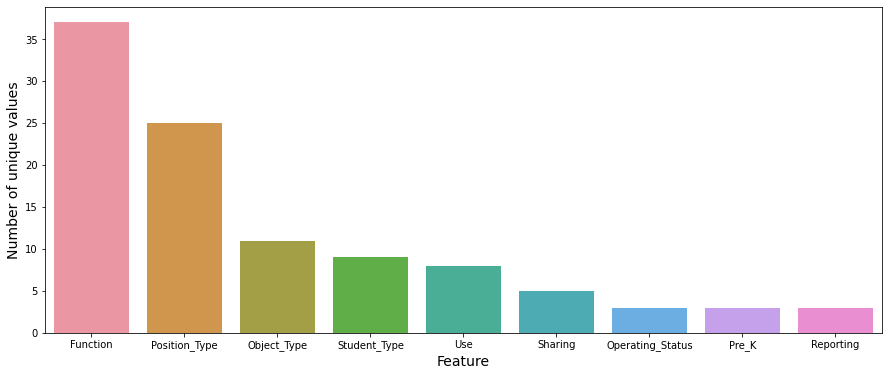

In [16]:
# display unique values for each feature
n_unique_features = df[categorical_cols].apply(pd.Series.nunique).sort_values(ascending=False)
sns.barplot(x=n_unique_features.index, y=n_unique_features.values)
plt.xlabel('Feature')
plt.ylabel('Number of unique values')

## Numerical Features

In [17]:
# look for possible numeric columns
numeric_cols = []
print("Numeric columns...")
for c in sorted(df.select_dtypes(include=["number"]).columns):
    print(f"  {c}")
    numeric_cols.append(c)

Numeric columns...
  FTE
  Total


In [18]:
numeric_data = df[numeric_cols].fillna(-1000)

## Text Features

In [19]:
non_text_cols = numeric_cols + categorical_cols
text_cols = []
print("Text columns...")
for c in sorted(df.columns):
    if c not in non_text_cols:
        print(f"  {c}")
        text_cols.append(c)

Text columns...
  Facility_or_Department
  Function_Description
  Fund_Description
  Job_Title_Description
  Location_Description
  Object_Description
  Position_Extra
  Program_Description
  SubFund_Description
  Sub_Object_Description
  Text_1
  Text_2
  Text_3
  Text_4


# Preprocessing

In [25]:
# take a sample to speed things up
SAMPLE_SIZE = 5000
train_df = multilabel_sample_dataframe(df,
                                       pd.get_dummies(
                                           df[categorical_cols]),
                                       size=SAMPLE_SIZE,
                                       min_count=25,
                                       seed=43)

In [26]:
# design matrix and OHE target values
features = numeric_cols + text_cols
X = train_df[features]
y = pd.get_dummies(train_df[categorical_cols])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(X,
                                                               y,
                                                               size=0.2,
                                                               seed=42)

# Modeling

Reminder, the conceptual framework for working with numeric, categorical, and text data is to use independent preprocessing pipelines.

In [27]:
# unique imports
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

In [28]:
# Preprocess the text data: get_text_data
select_text_data = FunctionTransformer(
    lambda x: x[text_cols].fillna("").apply(lambda y: " ".join(y), axis=1),
    validate=False)

# Preprocess the numeric data: get_numeric_data
select_numeric_data = FunctionTransformer(
    lambda x: x[numeric_cols],
    validate=False)

In [40]:
# Complete the pipeline in steps:
# 1. select numerical data
# 2. impute missing numeric values
# 3. select text data
# 4. tokenize and vectorize text
# 5. reduce the dimensionality by selecting k-best features
# 6. union the numeric and text subpipelines
# 7. calculate feature interactions
# 8. scale the resulting features
# 9. fit a multiclass classifier

# missing data imputer
imputer = SimpleImputer()

# the scaler
scaler = MaxAbsScaler()

# the token pattern to use
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
#vectorizer = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
#                             ngram_range=(1, 2))
vectorizer = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                               norm=None,
                               binary=False,
                               ngram_range=(1, 2))

# the best n-features
dimredux = SelectKBest(chi2, k=300)

# the model
model = OneVsRestClassifier(LogisticRegression())
#model = RandomForestClassifier(n_estimators=15)

# the pipeline
pipeline = Pipeline([
    (
        'union', FeatureUnion(transformer_list=[
            (
                'numeric_features',
                Pipeline([
                    ('num_selector', select_numeric_data),  # Step 1
                    ('imputer', imputer)                # Step 2
                ], verbose=True)),
            (
                'text_features',
                Pipeline([
                    ('txt_selector', select_text_data),     # Step 3
                    ('vectorizer', vectorizer),         # Step 4
                    #('dimredux', dimredux)              # Step 5
                ], verbose=True))
        ], n_jobs=-1, verbose=True)),
    ('interactions', SparseInteractions(degree=2)),     # Step 6
    ('scale', scaler),                                  # Step 7
    ('clf', model)                                      # Step 8
], verbose=True)

In [ ]:
# Fit to the training data
pipeline.fit(X_train, y_train)

[Pipeline] ............. (step 1 of 4) Processing union, total=   0.8s


In [ ]:
# Compute and print accuracy
accuracy = pipeline.score(X_test, y_test)
print("Accuracy on budget dataset: ", accuracy)

In [ ]:
# save model
model_name = "models/pipeline_rf.joblib"
joblib.dump(pipeline, model_name) 

In [ ]:
# reload model
clf = joblib.load(model_name) 

# Generate predictions: predictions
predictions = clf.predict_proba(test_df[numeric_cols].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(train_df[categorical_cols]).columns,
                             index=test_df.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv("datasets/predictions.csv")

<div class="alert alert-block alert-danger">
<b>WARNING</b></div>

Sorry, this exercise ends here because the peeps at Datacamp ensured that their tutorial is not fully reproducible by using a `score_submission` function that relies on a hidden file they do not share.

<div class="alert alert-block alert-danger">
<b>:(</b></div>